<p align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/7/74/Logo_%C3%89cole_normale_sup%C3%A9rieure_-_PSL_%28ENS-PSL%29.svg"
             alt="ENS-PSL"
             width="400"
             style="margin-right: 30px; display: inline-block; vertical-align: middle;"/>
    <img src="https://upload.wikimedia.org/wikipedia/fr/thumb/c/cd/AMF_2003_logo.svg/1200px-AMF_2003_logo.svg.png"
             alt="Crédit Agricole Assurances"
             width="300"
             style="display: inline-block; vertical-align: middle;"/>
</p>

# AMF - Automatic Title Extraction from Financial Documentation PDFs
**Classification for Document Intelligence & Layout NLP**

## Data Challenge 
**Powered by ENS** 

<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Curently ranked 6/32** on *https://challengedata.ens.fr/challenges/86*


The goal of the challenge is to be able to reconstruct the table of contents of annual financial reports of listed French companies, based on the text blocks of the document and their metadata (positions, font, text size, etc.).

This notebook presents a complete machine-learning pipeline to automatically detect titles and hierarchical headings inside financial documents (prospectuses, AMF regulatory PDFs, corporate reports, etc.).

Given thousands of text blocks extracted from the PDFs (OCR + layout parsing), our goal is to predict:

- **0** → not a title
- **1–8** → title level (increasing depth)

The model must reconstruct the structure of the document, block by block, exactly like a human reader identifying all titles and subtitles.

The screenshot below shows an example of the labeling tool developed by the AMF to annotate text blocks from annual financial reports.

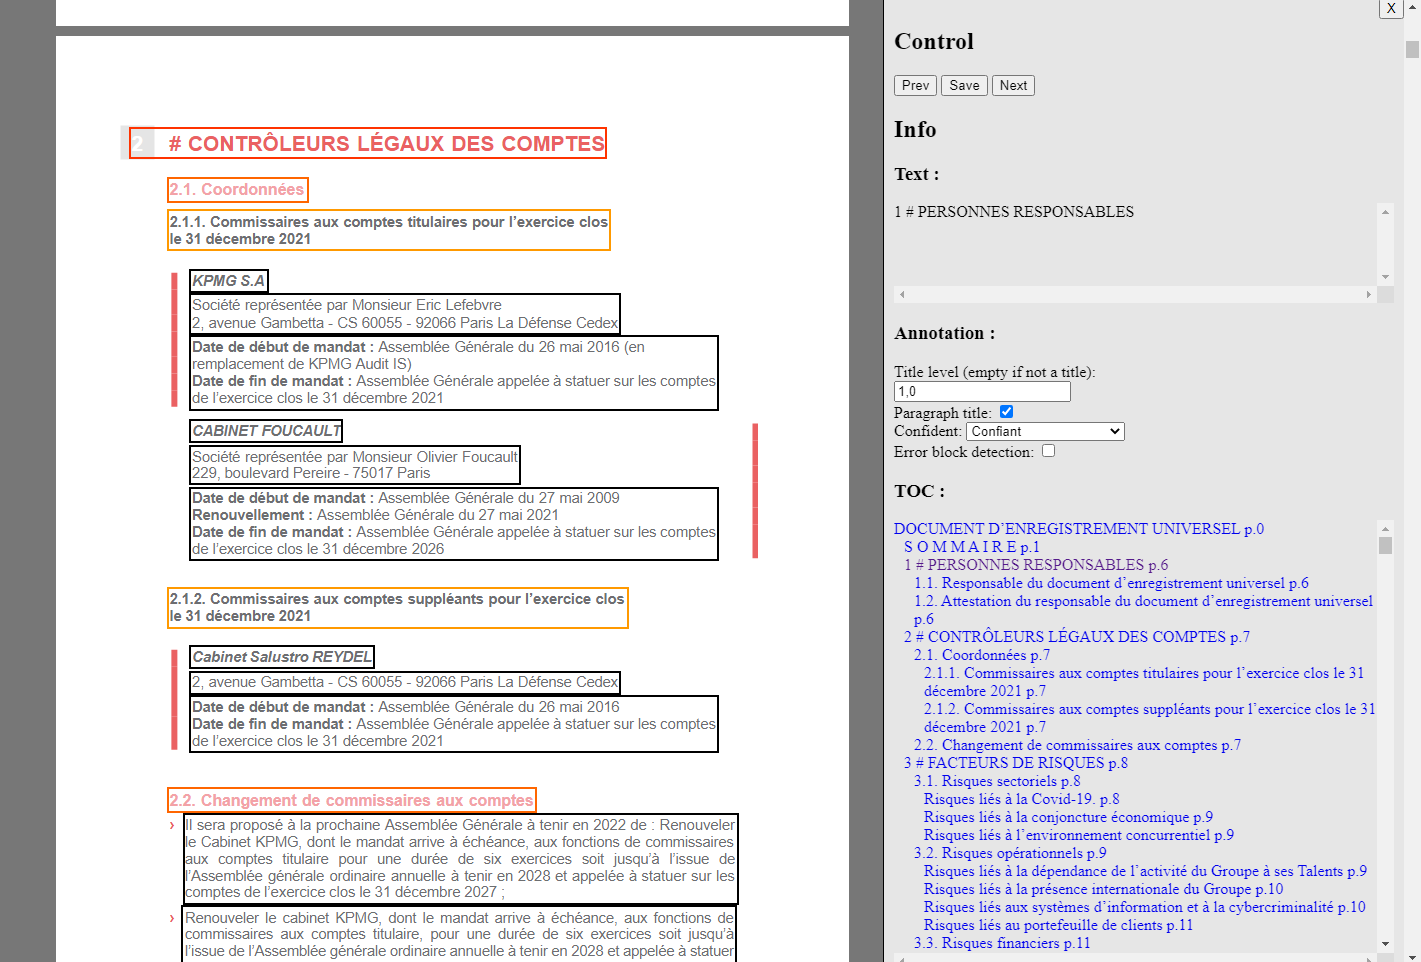

*It should be noted that annual financial reports are supposed to be produced in a "machine-readable" format (XHTML), following the entry into force in 2022 of the ESEF (European Single Electronic Format) regulation. However, the lack of use of specific tags beyond the sections covered by ESEF (such as IFRS consolidated accounts) makes these documents difficult to exploit in practice. In other words, it is not possible to identify the different sections of the document using XHTML tags (because they are very rarely used, or not at all).*

## Business context 

Financial and regulatory PDFs are massive and unstructured. Before any semantic NLP task (risk extraction, ESG scoring, section summarization…), a machine must understand how the document is organized.

This challenge aims to automate:

- **table-of-contents reconstruction**
- **section boundary detection**
- **document structural parsing**
- **hierarchical title classification**

This is a foundational block in industrial PDF intelligence pipelines used by:

- the **AMF**
- **asset managers**
- **auditors**
- **RegTech solutions**
- **ESG/finance analysts**


## Description of the Data

Three CSV files are provided:

#### 1) `x_train.csv` – PDF text blocks + layout features

Each row describes a single block of text extracted from the PDF, including:

- **`txt`** – raw text content
- **`font`**, **`font_style`**, **`font_color`**, **`font_size`** – typographic metadata
- **`x0`**, **`y0`**, **`x1`**, **`y1`** – local bounding box coordinates (page-level)
- **`orig_y0`**, **`orig_y1`** – vertical position in the full document (absolute)
- **`page_num`** – page number in the PDF
- **`file`**, **`idx`** – unique identifiers for document and text block

These features combine **linguistic** and **visual** signals to enable structural understanding of the document layout.

In [2]:
import pandas as pd

df = pd.read_csv("x_train.csv")
df.head()

,Unnamed: 0,file,page_num,idx,txt,x0,y0,orig_y0,x1,y1,orig_y1,font,font_size,font_color,font_style
0,0,2021-054000,0,0,2021,898,816,816.000000,1006,878,878.000000,"""ORTLAA+UbisoftSans-Regular""",507.2px,"rgb(255, 255, 255)",normal
1,1,2021-054000,0,1,DOCUMENT D’ENREGISTREMENT UNIVERSEL,696,886,886.000000,1206,1068,1068.000000,"""ASUBNF+UbisoftSans-Bold""",532.8px,"rgb(255, 255, 255)",normal
2,2,2021-054000,0,2,Incluant le rapport ﬁnancier annuel,750,1076,1076.000000,1154,1112,1112.000000,"""ORTLAA+UbisoftSans-Regular""",267.2px,"rgb(255, 255, 255)",normal
3,3,2021-054000,1,3,Sommaire,654,20,1151.288889,774,70,1201.288889,"""TSIVTF+UniversLTStd-UltraCn"", ""Times New Roman""",427.2px,"rgb(132, 161, 217)",normal
4,4,2021-054000,1,4,Message du Président-Directeur général,656,108,1239.288889,886,152,1283.288889,"""JESBER+UniversLTStd-BoldCn""",177.6px,"rgb(103, 121, 158)",normal


#### 2) `y_train.csv` – Title annotation

Each row corresponds to a text block in `x_train.csv` and contains:

- **`file`**, **`idx`** – identifiers matching `x_train.csv`
- **`annotation`** – the ground truth label:
    - **blank (NaN)** → not a title
    - **1–8** → hierarchical title levels (1 = top-level section, 8 = deepest subsection)

We convert these into a multiclass integer target:

- **0** = non-title
- **1** = title level 1
- **2** = title level 2
- **…**
- **K** = highest observed level (typically 8)


In [3]:
df = pd.read_csv("y_train.csv")
df.head()

,Unnamed: 0,file,idx,annotation
0,0,2021-054000,0,NaN
1,1,2021-054000,1,0.0
2,2,2021-054000,2,NaN
3,3,2021-054000,3,1.0
4,4,2021-054000,4,NaN


#### 3) `x_test.csv` – Unlabeled document blocks

Same structure as `x_train.csv` except for the missing annotation.

Our task is to produce `y_prediction.csv` with:

- **`file`** – document identifier
- **`idx`** – text block identifier
- **`annotation`** – predicted label (NaN for non-titles, 1–8 for hierarchical title levels)


In [4]:
df = pd.read_csv("x_test.csv")
df.head()

,Unnamed: 0,file,page_num,idx,txt,x0,y0,orig_y0,x1,y1,orig_y1,font,font_size,font_color,font_style
0,0,2022-038200,0,0,HOPSCOTCH GROUPE,798,616,616.0,1104,646,646.0,"""WCIAUQ+Arial""",240px,"rgb(109, 110, 113)",normal
1,1,2022-038200,0,1,DOCUMENT D’ENREGISTREMENT UNIVERSEL,654,718,718.0,1252,752,752.0,"""BIFJNJ+Arial Bold""",267.2px,"rgb(255, 255, 255)",normal
2,2,2022-038200,0,2,INCLUANT LE RAPPORT FINANCIER ANNUEL,806,770,770.0,1100,788,788.0,"""MAJNRN+Arial Bold""",132.8px,"rgb(243, 162, 167)",normal
3,3,2022-038200,0,3,EXERCICE 2021,852,810,810.0,1064,844,844.0,"""MAJNRN+Arial Bold""",267.2px,"rgb(109, 110, 113)",normal
4,4,2022-038200,0,4,Le document d’enregistrement universel a été d...,794,924,924.0,1284,1038,1038.0,"""MREPWR+Arial Narrow""",107.2px,"rgb(192, 192, 192)",normal


## How the scoring works (Black-Box)

We do not have access to the true test labels.

When we upload `y_prediction.csv`, the platform:
- matches predictions with hidden annotation labels
- computes the official multiclass score
- updates the leaderboard

This means all modeling decisions must rely on **internal validation**, not the hidden test set.

## Problems to solve

### 1. Extreme class imbalance
95%+ of blocks are **not titles**; a naïve classifier predicting only "class 0" would achieve high accuracy but **0 usefulness**.

### 2. Title heterogeneity
Titles vary widely: plain caps, bold fonts, centered or indented, numbered (`"1."`, `"2.1.3"`), sometimes very short, sometimes long.

### 3. Only flattened metadata (not raw PDF)
We never see alignment, spacing, or visual rendering.

Only **structured numerical + textual metadata**.

## Solution Strategy

To solve this, we combine **layout analysis**, **text-based heuristics**, and **tree-based models**.

## I - Feature Engineering

### Text-Based Features
- text length
- number of uppercase letters
- digit count
- punctuation frequency
- uppercase ratio
- "ALL CAPS" detection
- hierarchical numbering detection
    - `1.`, `2.1`, `3.2.4`
- title keywords:
    - `SOMMAIRE`
    - `DOCUMENT`
    - `TAXONOMIE`

### Layout Features
- **font size** (parsed: `"507px"` → `507`)
- **R, G, B** color extraction
- block **width** and **height**
- **vertical position normalized**:
    - per page
    - per document
- **bold detection** from:
    - `font`
    - `font_style`

### Per-Document Normalization
Different PDFs = different style guidelines.

We normalize:
- font sizes relative to document median
- vertical position relative to document max height

This ensures **robust cross-document generalization**.

## II - Handling Class Imbalance

We compute LightGBM-compatible sample weights:

$$w_c = \frac{N}{K \cdot n_c}$$

Where:
- $N$ = total samples
- $K$ = number of classes
- $n_c$ = samples of class $c$

This forces the model to pay **real attention to rare title levels**.

## III - Validation Strategy: Split by Document

A row-level random split is **forbidden**, because:
- blocks in the same PDF share formatting
- their features are correlated
- page context leaks across train/valid

**So we split by `file`**: train documents vs. validation documents.

This mimics the challenge's real generalization conditions: **unseen PDF styles**.

## IV - Model Choice: LightGBM Multiclass

We use **LightGBM** with:

- `num_leaves = 128`
- `min_data_in_leaf = 100`
- `learning_rate = 0.05`
- `bagging_fraction = 0.85`
- `feature_fraction = 0.85`
- `lambda_l2 = 1.0`
- **early stopping** = 100 rounds

**Optimal iterations**: ≈ 298.

It is a **simple, robust, non-overfitting** model tuned to preserve stability across documents.

## V - Local Validation Results

- **F1-micro** ~ 0.96 (dominated by class 0)
- **F1-macro** ~ 0.41

This is **consistent with real leaderboard scores**.

Rare classes (levels 6–8) remain very difficult, but the model handles **levels 1–5 well**.

## Further Improvements

**Better Features cues (spacing, indentation, Δy).**: Add **relational layout cues**: spacing between blocks, indentation depth, vertical distance (`Δy`), introduce **lightweight text embeddings** (TF-IDF / SIF), capture **page-level statistics** (block density, font diversity)

**Improved Modeling**: Try focal loss for rare classesare classes. Use a two-stage model (Binary: title vs. non-title ; Multiclass: level 1–8), experiment with **cost-sensitive learning** beyond simple weighting

**Smarter Validation**: Use **k-fold by document** instead of a single split, stratify by title distribution to ensure rare classes appear in each folddation

**Ensemblest instead of a single split**: Blend **LightGBM + CatBoost + XGBoost** for more stability, average probabilities across multiple seeds

# Code Pipeline

# 1. Imports, Data Loading & Target Construction

In [ ]:
# 1. Imports, read data, construction of the target

import numpy as np
import re
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import lightgbm as lgb

pd.set_option("display.max_columns", 200)

DATA_DIR = Path(".") 

def load_csv(name):
    path = DATA_DIR / name
    df = pd.read_csv(path)
    # On enlève une éventuelle colonne d'index laissée par pandas
    for col in ["Unnamed: 0", "Unnamed: 0.1"]:
        if col in df.columns:
            df = df.drop(columns=[col])
    return df

# Reading data
X_train = load_csv("x_train.csv")
y_train = load_csv("y_train.csv")
X_test  = load_csv("x_test.csv")

print("Shapes :")
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test  :", X_test.shape)

print("\nX_train head :")
display(X_train.head())

print("\ny_train head :")
display(y_train.head())

print("\nX_test head :")
display(X_test.head())

# Building the multiclass target
# Merge X_train and y_train to ensure proper alignment (for safety)
train = X_train.merge(y_train, on=["file", "idx"], how="left")

# annotation can be empty / NaN: convert properly
ann_raw = pd.to_numeric(train["annotation"], errors="coerce")

is_title = ~ann_raw.isna()
levels = sorted(ann_raw[is_title].unique())

print("Observed title levels:", levels)

# Mapping real levels -> classes 1..K
level_to_class = {lev: i+1 for i, lev in enumerate(levels)}
class_to_level = {v: k for k, v in level_to_class.items()}

# Creating the multiclass target variable
y_classes = np.zeros(len(train), dtype=int)  # 0 = non-title
y_classes[is_title.values] = ann_raw[is_title].map(level_to_class).astype(int).values

train["target_class"] = y_classes

display(train[["file", "idx", "annotation", "target_class"]].head(15))

Shapes :
X_train : (1072345, 14)
y_train : (1072345, 3)
X_test  : (252250, 14)

X_train head :


,file,page_num,idx,txt,x0,y0,orig_y0,x1,y1,orig_y1,font,font_size,font_color,font_style
0,2021-054000,0,0,2021,898,816,816.000000,1006,878,878.000000,"""ORTLAA+UbisoftSans-Regular""",507.2px,"rgb(255, 255, 255)",normal
1,2021-054000,0,1,DOCUMENT D’ENREGISTREMENT UNIVERSEL,696,886,886.000000,1206,1068,1068.000000,"""ASUBNF+UbisoftSans-Bold""",532.8px,"rgb(255, 255, 255)",normal
2,2021-054000,0,2,Incluant le rapport ﬁnancier annuel,750,1076,1076.000000,1154,1112,1112.000000,"""ORTLAA+UbisoftSans-Regular""",267.2px,"rgb(255, 255, 255)",normal
3,2021-054000,1,3,Sommaire,654,20,1151.288889,774,70,1201.288889,"""TSIVTF+UniversLTStd-UltraCn"", ""Times New Roman""",427.2px,"rgb(132, 161, 217)",normal
4,2021-054000,1,4,Message du Président-Directeur général,656,108,1239.288889,886,152,1283.288889,"""JESBER+UniversLTStd-BoldCn""",177.6px,"rgb(103, 121, 158)",normal



y_train head :


,file,idx,annotation
0,2021-054000,0,NaN
1,2021-054000,1,0.0
2,2021-054000,2,NaN
3,2021-054000,3,1.0
4,2021-054000,4,NaN



X_test head :


,file,page_num,idx,txt,x0,y0,orig_y0,x1,y1,orig_y1,font,font_size,font_color,font_style
0,2022-038200,0,0,HOPSCOTCH GROUPE,798,616,616.0,1104,646,646.0,"""WCIAUQ+Arial""",240px,"rgb(109, 110, 113)",normal
1,2022-038200,0,1,DOCUMENT D’ENREGISTREMENT UNIVERSEL,654,718,718.0,1252,752,752.0,"""BIFJNJ+Arial Bold""",267.2px,"rgb(255, 255, 255)",normal
2,2022-038200,0,2,INCLUANT LE RAPPORT FINANCIER ANNUEL,806,770,770.0,1100,788,788.0,"""MAJNRN+Arial Bold""",132.8px,"rgb(243, 162, 167)",normal
3,2022-038200,0,3,EXERCICE 2021,852,810,810.0,1064,844,844.0,"""MAJNRN+Arial Bold""",267.2px,"rgb(109, 110, 113)",normal
4,2022-038200,0,4,Le document d’enregistrement universel a été d...,794,924,924.0,1284,1038,1038.0,"""MREPWR+Arial Narrow""",107.2px,"rgb(192, 192, 192)",normal


Observed title levels: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0)]


,file,idx,annotation,target_class
0,2021-054000,0,NaN,0
1,2021-054000,1,0.0,1
2,2021-054000,2,NaN,0
3,2021-054000,3,1.0,2
4,2021-054000,4,NaN,0
5,2021-054000,5,NaN,0
6,2021-054000,6,NaN,0
7,2021-054000,7,NaN,0
8,2021-054000,8,NaN,0
9,2021-054000,9,NaN,0


# 2. Feature engineering + features selection + split by document

In [6]:
# 2. Feature engineering (text + layout) + feature selection + split

# 2.1 Parsing of raw fields

def parse_font_size(s):
    # ex: "507.2px"
    if pd.isna(s):
        return np.nan
    return float(str(s).replace("px", "").strip())

def parse_rgb(s):
    # ex: "rgb(255, 255, 255)" or "rgba(0,0,0,1)"
    if pd.isna(s):
        return (np.nan, np.nan, np.nan)
    m = re.findall(r"\d+", str(s))
    if len(m) >= 3:
        return (int(m[0]), int(m[1]), int(m[2]))
    return (np.nan, np.nan, np.nan)

# 2.2 Simple text features

UPPER_CHARS = re.compile(r"[A-ZÀ-ÖØ-Ý]")
DIGIT_CHARS = re.compile(r"\d")
PUNCT_CHARS = re.compile(r"[.,;:!?•\-]")

def add_text_features(df):
    txt = df["txt"].fillna("").astype(str)
    
    df["text_len"] = txt.str.len()
    df["n_words"] = txt.str.split().apply(len)
    
    df["n_upper"] = txt.apply(lambda s: len(UPPER_CHARS.findall(s)))
    df["n_digits"] = txt.apply(lambda s: len(DIGIT_CHARS.findall(s)))
    df["n_punct"] = txt.apply(lambda s: len(PUNCT_CHARS.findall(s)))
    
    # ratios
    df["upper_ratio"] = df["n_upper"] / df["text_len"].replace(0, np.nan)
    df["digit_ratio"] = df["n_digits"] / df["text_len"].replace(0, np.nan)
    df["punct_ratio"] = df["n_punct"] / df["text_len"].replace(0, np.nan)
    
    # all caps text (excluding punctuation/digits)
    def is_all_caps(s):
        letters = re.sub(r"[^A-Za-zÀ-ÖØ-Ý]", "", s)
        if len(letters) == 0:
            return 0
        return int(letters.upper() == letters)
    
    df["is_all_caps"] = txt.apply(is_all_caps)
    
    # Numbering like "1.", "1.2", "2.3.4", etc. at the beginning of the line
    def numbering_depth(s):
        m = re.match(r"^\s*(\d+(\.\d+){0,5})\b", s)
        if not m:
            return 0
        return m.group(1).count(".") + 1  # 1 = "1.", 2 = "1.2", ...
    
    df["numbering_depth"] = txt.apply(numbering_depth)
    df["starts_with_numbering"] = (df["numbering_depth"] > 0).astype(int)
    
    # Frequent keywords in AMF titles / taxonomy
    df["has_mot_sommaire"] = txt.str.contains(r"\bSOMMAIRE\b", case=False, regex=True).astype(int)
    df["has_mot_taxonomie"] = txt.str.contains(r"TAXONOMIE", case=False, regex=True).astype(int)
    df["has_mot_document"] = txt.str.contains(r"DOCUMENT", case=False, regex=True).astype(int)

# 2.3 Geometric and font features

def add_layout_features(df):
    # numeric sizes
    df["font_size_num"] = df["font_size"].apply(parse_font_size)
    
    # colors
    rgb = df["font_color"].apply(parse_rgb)
    df["font_r"] = [t[0] for t in rgb]
    df["font_g"] = [t[1] for t in rgb]
    df["font_b"] = [t[2] for t in rgb]
    
    # block width / height
    df["block_width"]  = df["x1"] - df["x0"]
    df["block_height"] = df["y1"] - df["y0"]
    
    # normalization by file
    group_file = df.groupby("file")
    max_y1_doc = group_file["orig_y1"].transform("max")
    med_font_doc = group_file["font_size_num"].transform("median")
    
    df["y0_norm_doc"] = df["orig_y0"] / max_y1_doc.replace(0, np.nan)
    df["y1_norm_doc"] = df["orig_y1"] / max_y1_doc.replace(0, np.nan)
    df["font_size_rel_doc"] = df["font_size_num"] / med_font_doc.replace(0, np.nan)
    
    # normalization by (file, page_num)
    group_page = df.groupby(["file", "page_num"])
    max_y1_page = group_page["y1"].transform("max")
    df["y0_norm_page"] = df["y0"] / max_y1_page.replace(0, np.nan)
    df["y1_norm_page"] = df["y1"] / max_y1_page.replace(0, np.nan)
    
    # Bold ?
    df["is_bold_name"] = df["font"].astype(str).str.contains("Bold", case=False, regex=False).astype(int)
    df["is_bold_style"] = df["font_style"].astype(str).str.contains("bold", case=False, regex=False).astype(int)

# 2.4 Application of features on train and test ----

train_feat = train.copy()
test_feat  = X_test.copy()

print("Adding text/layout features on train...")
add_text_features(train_feat)
add_layout_features(train_feat)

print("Adding text/layout features on test...")
add_text_features(test_feat)
add_layout_features(test_feat)

# 2.5 Feature selection

cols_exclude = [
    "txt",
    "annotation",
    "target_class",
]

feature_cols = [
    c for c in train_feat.columns
    if c not in cols_exclude
    and c not in ["idx"]  # idx useful for join but not for model
]

numeric_feature_cols = (
    train_feat[feature_cols]
    .select_dtypes(include=['int64', 'float64', 'bool'])
    .columns
    .tolist()
)

print("Nb de features totales :", len(feature_cols))
print("Nb de features numériques utilisées :", len(numeric_feature_cols))
print("Exemples :", numeric_feature_cols[:20])

# 2.6 Split by files for validation

unique_files = train_feat["file"].unique()
rng = np.random.RandomState(42)
rng.shuffle(unique_files)

n_valid_files = max(1, int(0.2 * len(unique_files)))
val_files = set(unique_files[:n_valid_files])
train_files = set(unique_files[n_valid_files:])

train_mask = train_feat["file"].isin(train_files)
val_mask   = train_feat["file"].isin(val_files)

X_tr = train_feat.loc[train_mask, numeric_feature_cols]
y_tr = train_feat.loc[train_mask, "target_class"].astype(int)

X_val = train_feat.loc[val_mask, numeric_feature_cols]
y_val = train_feat.loc[val_mask, "target_class"].astype(int)

print(f"Train size: {len(X_tr)}, Val size: {len(X_val)}")
print(f"Train files: {len(train_files)}, Val files: {len(val_files)}")

print("\nClass distribution in train:")
print(y_tr.value_counts().sort_index())

# 2.7 Class weights and LightGBM hyperparameters

class_counts = y_tr.value_counts().to_dict()
n_samples = len(y_tr)
n_classes = len(class_counts)

class_weight = {}
for cls, cnt in class_counts.items():
    class_weight[cls] = n_samples / (n_classes * cnt)

print("\nClass weights :", class_weight)

# LightGBM parameters
lgb_params = {
    "objective": "multiclass",
    "num_class": len(class_counts),   # classes 0..K
    "metric": "multi_logloss",
    "learning_rate": 0.05,
    "num_leaves": 128,            # ↑ 64 → 128 to capture more patterns
    "max_depth": -1,
    "min_data_in_leaf": 100,      # ↓ 200 → 100 to less smooth rare classes
    "feature_fraction": 0.85,     # slight regularization
    "bagging_fraction": 0.85,
    "bagging_freq": 1,
    "class_weight": class_weight,
    "lambda_l2": 1.0,             # light L2 regularization
    "n_jobs": -1,
    "random_state": 42,
}

Adding text/layout features on train...
Adding text/layout features on test...
Nb de features totales : 39
Nb de features numériques utilisées : 34
Exemples : ['page_num', 'x0', 'y0', 'orig_y0', 'x1', 'y1', 'orig_y1', 'text_len', 'n_words', 'n_upper', 'n_digits', 'n_punct', 'upper_ratio', 'digit_ratio', 'punct_ratio', 'is_all_caps', 'numbering_depth', 'starts_with_numbering', 'has_mot_sommaire', 'has_mot_taxonomie']
Train size: 850228, Val size: 222117
Train files: 57, Val files: 14

Class distribution in train:
target_class
0    815354
1        55
2       663
3      3747
4      9674
5     11675
6      6853
7      1825
8       382
Name: count, dtype: int64

Class weights : {0: 0.11586351177252797, 5: 8.091629788246491, 4: 9.765327452737004, 6: 13.78517113348574, 3: 25.212110429084007, 7: 51.76426179604262, 2: 142.48835260599967, 8: 247.30308318789994, 1: 1717.6323232323232}


# 3. LightGBM Train + local evaluation

In [7]:
# 3. Train LightGBM and local evaluation

# Sample weights from class_weight
sample_weights = np.array([class_weight[cls] for cls in y_tr])

lgb_train = lgb.Dataset(X_tr, label=y_tr, weight=sample_weights)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Remove class_weight from params because we use sample weights directly
lgb_params_train = {k: v for k, v in lgb_params.items() if k != 'class_weight'}

model = lgb.train(
    lgb_params_train,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100),
    ],
)

best_iter = model.best_iteration
print("Best iteration :", best_iter)

# Predictions on validation
y_val_pred_proba = model.predict(X_val, num_iteration=best_iter)
y_val_pred = y_val_pred_proba.argmax(axis=1)

print("F1 micro (including non-titles) :", f1_score(y_val, y_val_pred, average="micro"))
print("F1 macro :", f1_score(y_val, y_val_pred, average="macro"))

print("\nClassification report (attention: class 0 = non-title)")
print(classification_report(y_val, y_val_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5999
[LightGBM] [Info] Number of data points in the train set: 850228, number of used features: 33
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

# 4. Complete Re train + test predictions + CSV (y_prediction + indexed)

In [8]:
# 4. Re-train on full train and test predictions

# Use the same numeric columns
print("Number of numeric features used for full train:", len(numeric_feature_cols))

X_full = train_feat[numeric_feature_cols]
y_full = train_feat["target_class"].astype(int)

# Sample weights on full train, based on the same class_weight
sample_weights_full = np.array([class_weight[cls] for cls in y_full])

lgb_train_full = lgb.Dataset(X_full, label=y_full, weight=sample_weights_full)

# Remove class_weight here as well
lgb_params_full = {k: v for k, v in lgb_params.items() if k != 'class_weight'}

model_full = lgb.train(
    lgb_params_full,
    lgb_train_full,
    num_boost_round=best_iter,
    valid_sets=[lgb_train_full],
    valid_names=["train_full"],
    callbacks=[lgb.log_evaluation(period=100)],
)

print("Final model trained on full train.")

# Features of the test set
X_test_feat = test_feat[numeric_feature_cols]

# Probabilities / classes
test_proba = model_full.predict(X_test_feat, num_iteration=best_iter)
test_pred_class = test_proba.argmax(axis=1)

# Conversion classes -> annotation (level) or NaN
def class_to_annotation(cls):
    if cls == 0:
        return np.nan
    return class_to_level.get(cls, np.nan)

annotation_pred = [class_to_annotation(c) for c in test_pred_class]

submission = pd.DataFrame({
    "file": X_test["file"],
    "idx": X_test["idx"],
    "annotation": annotation_pred,
})

print(submission.head(20))
print("\nDistribution of predicted annotations:")
print(submission["annotation"].value_counts(dropna=False).sort_index())

# Sanity checks
assert submission.shape[0] == X_test.shape[0]
assert submission[["file", "idx"]].isna().sum().sum() == 0

print("\nNumber of NaN in annotation (predicted non-titles) :", submission["annotation"].isna().sum())

# Export standard
out_path = DATA_DIR / "y_prediction.csv"
submission.to_csv(out_path, index=False)
print(f">> y_prediction.csv written to: {out_path.resolve()}")

# Variant with empty index column

y_pred_df = pd.read_csv(out_path)

# Create a new index column at the first position, named '' as in y_train.csv
y_pred_df.insert(0, '', range(len(y_pred_df)))

output_path = DATA_DIR / "y_prediction_indexed.csv"
y_pred_df.to_csv(output_path, index=False)

print(f"\n✓ File y_prediction_indexed.csv written with empty index column")
print(f"  Number of lines : {len(y_pred_df)}")
print("\nPreview of the first lines :")
print(y_pred_df.head(10))

Number of numeric features used for full train: 34
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6038
[LightGBM] [Info] Number of data points in the train set: 1072345, number of used features: 33
[LightGBM] [Info] Start training from score -2.192923
[LightGBM] [Info] Start training from score -2.197912
[LightGBM] [Info] Start training from score -2.151818
[LightGBM] [Info] Start training from score -2.181828
[LightGBM] [Info] Start training from score -2.186481
[LightGBM] [Info] Start training from score -2.188927
[LightGBM] [Info] Start training from score -2.166697
[LightGBM] [Info] Start training from score -2.211785
[LightGBM] [Info] Start training from score -2.303997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s